In [292]:
import numpy as np
import time
import matplotlib.pyplot as plt

In [293]:
from qiskit import *
from qiskit.pulse import *
from qiskit.tools.monitor import job_monitor
from qiskit.visualization import plot_histogram
import qiskit.pulse.pulse_lib as pulse_lib
import qiskit.tools.jupyter

In [294]:
IBMQ.load_account() # Load account from disk
IBMQ.providers()    # List all available providers

/Users/pranavgokhale/anaconda3/lib/python3.7/site-packages/qiskit/providers/ibmq/ibmqfactory.py:181: UserWarning: Credentials are already in use. The existing account in the session will be replaced.
  warnings.warn('Credentials are already in use. The existing '


[<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>,
 <AccountProvider for IBMQ(hub='ibm-q-ornl', group='bes-qis', project='argonne')>]

In [295]:
provider = IBMQ.get_provider(group='bes-qis')
backend = provider.get_backend('ibmq_boeblingen')
system = pulse.PulseChannelSpec.from_backend(backend)
config = backend.configuration()
defaults = backend.defaults()
cmd_def = pulse.CmdDef.from_defaults(backend.defaults().cmd_def, backend.defaults().pulse_library)

In [268]:
%qiskit_job_watcher

Accordion(children=(VBox(layout=Layout(max_width='610px', min_width='610px')),), layout=Layout(max_height='500…

<IPython.core.display.Javascript object>

----

In [12]:
num_drive_amps = 11
drive_amps = np.linspace(0, 0.05, num_drive_amps)
drive_samples = 128
drive_sigma = 16

print(drive_amps)

[0.    0.005 0.01  0.015 0.02  0.025 0.03  0.035 0.04  0.045 0.05 ]


In [13]:
measure = cmd_def.get('measure', qubits=config.meas_map[0])

In [28]:
schedules = []
for drive_amp in drive_amps:
    rabi_pulse = pulse_lib.gaussian(duration=drive_samples,
                                    amp=drive_amp,
                                    sigma=drive_sigma,
                                    name='rabi_pulse_with_drive_amp_%s' % drive_amp)
    
    # add commands to schedule
    schedule = pulse.Schedule(name='Rabi Experiment at drive amp = %s' % drive_amp)
    
    schedule |= rabi_pulse(system.qubits[0].drive)
    schedule |= measure << schedule.duration
 
    schedules.append(schedule)

In [33]:
qobj = assemble(schedules, backend, shots=512)
job = backend.run(qobj)

In [34]:
job.job_id()

'5d890be14a13e1001863a9a6'

In [49]:
frac_ones = []
for i in range(num_drive_amps):
    counts = job.result().get_counts(i)
    num_ones = sum({freq for (bitstring, freq) in counts.items() if bitstring.endswith('1')})
    frac_ones.append(num_ones / 512)

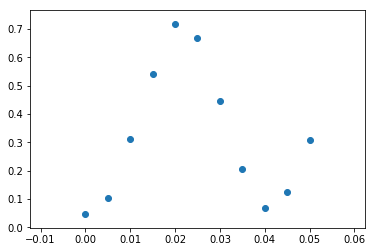

In [51]:
plt.scatter(drive_amps, frac_ones)

----

---
## Try again, zoomed in to optimal amplitude

In [91]:
num_drive_amps = 21
drive_amps = np.linspace(0.015, 0.025, num_drive_amps)
drive_samples = 128
drive_sigma = 16

print(drive_amps)

[0.015  0.0155 0.016  0.0165 0.017  0.0175 0.018  0.0185 0.019  0.0195
 0.02   0.0205 0.021  0.0215 0.022  0.0225 0.023  0.0235 0.024  0.0245
 0.025 ]


In [92]:
measure = cmd_def.get('measure', qubits=config.meas_map[0])

In [93]:
schedules = []
for drive_amp in drive_amps:
    rabi_pulse = pulse_lib.gaussian(duration=drive_samples,
                                    amp=drive_amp,
                                    sigma=drive_sigma,
                                    name='rabi_pulse_with_drive_amp_%s' % drive_amp)
    
    # add commands to schedule
    schedule = pulse.Schedule(name='Rabi Experiment at drive amp = %s' % drive_amp)
    
    schedule |= rabi_pulse(system.qubits[0].drive)
    schedule |= measure << schedule.duration
 
    schedules.append(schedule)

In [94]:
qobj = assemble(schedules, backend, shots=1024)
job = backend.run(qobj)
job.job_id()

'5d891e034a13e1001863a9ba'

In [97]:
frac_ones = []
for i in range(num_drive_amps):
    counts = job.result().get_counts(i)
    num_ones = sum({freq for (bitstring, freq) in counts.items() if bitstring.endswith('1')})
    frac_ones.append(num_ones / 1024)

(0.015, 0.025)

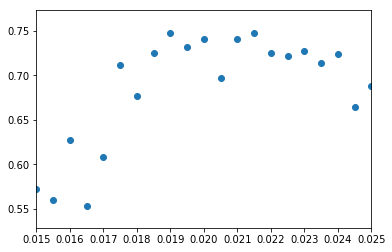

In [105]:
plt.scatter(drive_amps, frac_ones)
plt.xticks(np.arange(0.015, 0.025, step=0.001))
plt.xlim(0.015, 0.025)

In [130]:
print('amplitude is %s' % drive_amps[10])
print('sigma is %s' % drive_sigma)
print('duration is %s' % drive_samples)
print('integral is %s' % sum(schedules[10].instructions[0][1].command.samples))

amplitude is 0.02
sigma is 16
duration is 128
integral is (0.8020699602267553+0j)


---
## Try a faster (shorter duration) X pulse

In [131]:
num_drive_amps = 10
drive_amps = np.linspace(0.06, 0.10, num_drive_amps)
drive_samples = 32
drive_sigma = 4

print(drive_amps)

[0.06       0.06444444 0.06888889 0.07333333 0.07777778 0.08222222
 0.08666667 0.09111111 0.09555556 0.1       ]


In [133]:
schedules = []
for drive_amp in drive_amps:
    rabi_pulse = pulse_lib.gaussian(duration=drive_samples,
                                    amp=drive_amp,
                                    sigma=drive_sigma,
                                    name='rabi_pulse_with_drive_amp_%s' % drive_amp)
    
    # add commands to schedule
    schedule = pulse.Schedule(name='Rabi Experiment at drive amp = %s' % drive_amp)
    
    schedule |= rabi_pulse(system.qubits[0].drive)
    schedule |= measure << schedule.duration
 
    schedules.append(schedule)

In [134]:
qobj = assemble(schedules, backend, shots=512)
job = backend.run(qobj)
job.job_id()

'5d89245801bf92001948dc65'

In [137]:
frac_ones = []
for i in range(num_drive_amps):
    counts = job.result().get_counts(i)
    num_ones = sum({freq for (bitstring, freq) in counts.items() if bitstring.endswith('1')})
    frac_ones.append(num_ones / 512)

(0.06, 0.1)

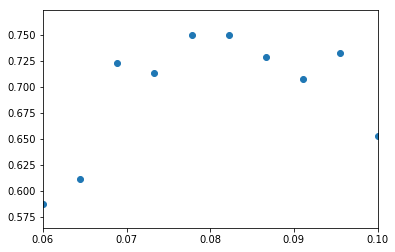

In [138]:
plt.scatter(drive_amps, frac_ones)
plt.xticks(np.arange(0.06, 0.10, step=0.01))
plt.xlim(0.06, 0.10)

---
## Go even faster (this is the best one)

In [140]:
num_drive_amps = 10
drive_amps = np.linspace(0.24, 0.40, num_drive_amps)
drive_samples = 8
drive_sigma = 1

print(drive_amps)

[0.24       0.25777778 0.27555556 0.29333333 0.31111111 0.32888889
 0.34666667 0.36444444 0.38222222 0.4       ]


In [142]:
schedules = []
for drive_amp in drive_amps:
    rabi_pulse = pulse_lib.gaussian(duration=drive_samples,
                                    amp=drive_amp,
                                    sigma=drive_sigma,
                                    name='rabi_pulse_with_drive_amp_%s' % drive_amp)
    
    # add commands to schedule
    schedule = pulse.Schedule(name='Rabi Experiment at drive amp = %s' % drive_amp)
    
    schedule |= rabi_pulse(system.qubits[0].drive)
    schedule |= measure << schedule.duration
 
    schedules.append(schedule)

In [143]:
qobj = assemble(schedules, backend, shots=512)
job = backend.run(qobj)
job.job_id()

'5d89256048b726001ab3c3a1'

In [144]:
frac_ones = []
for i in range(num_drive_amps):
    counts = job.result().get_counts(i)
    num_ones = sum({freq for (bitstring, freq) in counts.items() if bitstring.endswith('1')})
    frac_ones.append(num_ones / 512)

(0.24, 0.4)

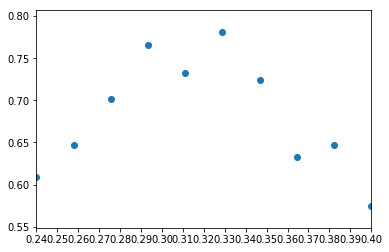

In [145]:
plt.scatter(drive_amps, frac_ones)
plt.xticks(np.arange(0.24, 0.40, step=0.01))
plt.xlim(0.24, 0.40)

---
## Super fast (too fast):

In [163]:
num_drive_amps = 10
drive_amps = np.linspace(0.44, 0.56, num_drive_amps)
drive_samples = 4
drive_sigma = 0.5

print(drive_amps)

[0.44       0.45333333 0.46666667 0.48       0.49333333 0.50666667
 0.52       0.53333333 0.54666667 0.56      ]


In [164]:
schedules = []
for drive_amp in drive_amps:
    rabi_pulse = pulse_lib.gaussian(duration=drive_samples,
                                    amp=drive_amp,
                                    sigma=drive_sigma,
                                    name='rabi_pulse_with_drive_amp_%s' % drive_amp)
    
    # add commands to schedule
    schedule = pulse.Schedule(name='Rabi Experiment at drive amp = %s' % drive_amp)
    
    schedule |= rabi_pulse(system.qubits[0].drive)
    schedule |= measure << schedule.duration
 
    schedules.append(schedule)

In [165]:
qobj = assemble(schedules, backend, shots=512)
job = backend.run(qobj)
job.job_id()

'5d892dc348b726001ab3c3ad'

In [166]:
frac_ones = []
for i in range(num_drive_amps):
    counts = job.result().get_counts(i)
    num_ones = sum({freq for (bitstring, freq) in counts.items() if bitstring.endswith('1')})
    frac_ones.append(num_ones / 512)

(0.44, 0.56)

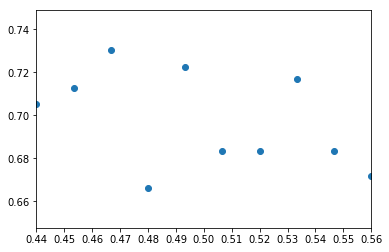

In [167]:
plt.scatter(drive_amps, frac_ones)
plt.xticks(np.arange(0.44, 0.56, step=0.01))
plt.xlim(0.44, 0.56)

---
## A little slower

In [168]:
num_drive_amps = 10
drive_amps = np.linspace(0.34, 0.56, num_drive_amps)
drive_samples = 6
drive_sigma = 0.75

print(drive_amps)

[0.34       0.36444444 0.38888889 0.41333333 0.43777778 0.46222222
 0.48666667 0.51111111 0.53555556 0.56      ]


In [169]:
schedules = []
for drive_amp in drive_amps:
    rabi_pulse = pulse_lib.gaussian(duration=drive_samples,
                                    amp=drive_amp,
                                    sigma=drive_sigma,
                                    name='rabi_pulse_with_drive_amp_%s' % drive_amp)
    
    # add commands to schedule
    schedule = pulse.Schedule(name='Rabi Experiment at drive amp = %s' % drive_amp)
    
    schedule |= rabi_pulse(system.qubits[0].drive)
    schedule |= measure << schedule.duration
 
    schedules.append(schedule)

In [170]:
qobj = assemble(schedules, backend, shots=512)
job = backend.run(qobj)
job.job_id()

'5d893832a807ac0018bac7b1'

In [171]:
frac_ones = []
for i in range(num_drive_amps):
    counts = job.result().get_counts(i)
    num_ones = sum({freq for (bitstring, freq) in counts.items() if bitstring.endswith('1')})
    frac_ones.append(num_ones / 512)

Error checking job status using websocket, retrying using HTTP.


(0.34, 0.56)

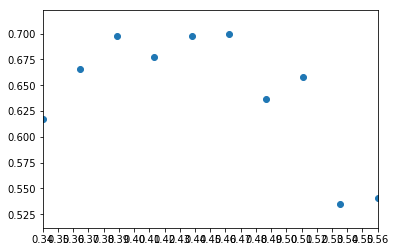

In [173]:
plt.scatter(drive_amps, frac_ones)
plt.xticks(np.arange(0.34, 0.56, step=0.01))
plt.xlim(0.34, 0.56)

---
## Compare to calibrated X gate

In [174]:
schedule = pulse.Schedule()
schedule |= cmd_def.get('x', qubits=[0])
schedule |= measure << schedule.duration

In [175]:
job = execute(schedule, backend=backend)
print(job.job_id())

5d8949641765500018c3e487


0.87109375


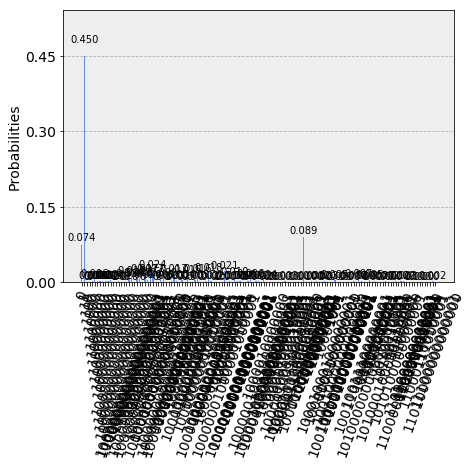

In [178]:
counts = job.result().get_counts()
counts = {key: value for key, value in counts.items()}
num_ones = sum({key: value for (key,value) in counts.items() if key[-1] == '1'}.values())
print(num_ones/1024)
plot_histogram(counts)

In [183]:
cmd_def.cmds()

['cx', 'id', 'measure', 'u1', 'u2', 'u3', 'x']

In [306]:
[_ for _ in backend.defaults().cmd_def if _.name=='u3']

[Command(name='u3', qubits=[0], sequence=[PulseQobjInstruction(ch='d0', name='fc', phase='-(P2)', t0=0), PulseQobjInstruction(ch='u1', name='fc', phase='1*(-(P2))', t0=0), PulseQobjInstruction(ch='d0', name='X90p_d0', t0=0), PulseQobjInstruction(ch='d0', name='fc', phase='-(P0)', t0=10), PulseQobjInstruction(ch='u1', name='fc', phase='1*(-(P0))', t0=10), PulseQobjInstruction(ch='d0', name='X90m_d0', t0=10), PulseQobjInstruction(ch='d0', name='fc', phase='-(P1)', t0=20), PulseQobjInstruction(ch='u1', name='fc', phase='1*(-(P1))', t0=20)]),
 Command(name='u3', qubits=[1], sequence=[PulseQobjInstruction(ch='d1', name='fc', phase='-(P2)', t0=0), PulseQobjInstruction(ch='u0', name='fc', phase='1*(-(P2))', t0=0), PulseQobjInstruction(ch='u4', name='fc', phase='1*(-(P2))', t0=0), PulseQobjInstruction(ch='u12', name='fc', phase='1*(-(P2))', t0=0), PulseQobjInstruction(ch='d1', name='X90p_d1', t0=0), PulseQobjInstruction(ch='d1', name='fc', phase='-(P0)', t0=10), PulseQobjInstruction(ch='u0', n

In [315]:
for instruction in cmd_def.get('cx', [1, 0]).instructions:
    print(instruction, instruction[1].channels)

(0, FrameChange(fc1844, phase=-1.571)) (DriveChannel(0),)
(0, FrameChange(fc1847, phase=3.142)) (ControlChannel(0),)
(0, FrameChange(fc1845, phase=4.712)) (ControlChannel(1),)
(0, FrameChange(fc1846, phase=-3.142)) (DriveChannel(1),)
(0, FrameChange(fc1848, phase=3.142)) (ControlChannel(4),)
(0, FrameChange(fc1849, phase=3.142)) (ControlChannel(12),)
(0, SamplePulse(X90p_d0, duration=10)) (DriveChannel(0),)
(0, SamplePulse(Y90p_d1, duration=10)) (DriveChannel(1),)
(10, SamplePulse(CR90p_u0, duration=21)) (ControlChannel(0),)
(10, SamplePulse(CR90p_d1, duration=50)) (DriveChannel(1),)
(60, SamplePulse(Xp_d0, duration=10)) (DriveChannel(0),)
(70, SamplePulse(CR90m_u0, duration=21)) (ControlChannel(0),)
(70, SamplePulse(CR90m_d1, duration=50)) (DriveChannel(1),)
(120, FrameChange(fc1851, phase=4.712)) (ControlChannel(0),)
(120, FrameChange(fc1850, phase=-1.571)) (DriveChannel(1),)
(120, FrameChange(fc1852, phase=4.712)) (ControlChannel(4),)
(120, FrameChange(fc1853, phase=4.712)) (Control

In [320]:
for instruction in cmd_def.get('cx', [0, 1]).instructions:
    print(instruction, instruction[1].channels)

(0, FrameChange(fc1842, phase=1.571)) (DriveChannel(0),)
(0, FrameChange(fc1843, phase=1.571)) (ControlChannel(1),)
(0, SamplePulse(Ym_d0, duration=10)) (DriveChannel(0),)
(0, SamplePulse(X90p_d1, duration=10)) (DriveChannel(1),)
(10, SamplePulse(CR90p_u0, duration=21)) (ControlChannel(0),)
(10, SamplePulse(CR90p_d1, duration=50)) (DriveChannel(1),)
(60, SamplePulse(Xp_d0, duration=10)) (DriveChannel(0),)
(70, SamplePulse(CR90m_u0, duration=21)) (ControlChannel(0),)
(70, SamplePulse(CR90m_d1, duration=50)) (DriveChannel(1),)


In [254]:
pulse = [p for p in backend.defaults().pulse_library if p.name=='Xp_d0'][0]
pulse

PulseLibraryItem(name='Xp_d0', samples=[(0.018498815596103668-0.002388204215094447j), (0.0486144982278347-0.003522698301821947j), (0.08786392956972122-0.00406638765707612j), (0.12669236958026886-0.0033599610906094313j), (0.15129391849040985-0.0013143169926479459j), (0.15129391849040985+0.0013143169926479459j), (0.12669236958026886+0.0033599610906094313j), (0.08786392956972122+0.00406638765707612j), (0.0486144982278347+0.003522698301821947j), (0.018498815596103668+0.002388204215094447j)])

In [253]:
pulse = [p for p in backend.defaults().pulse_library if p.name=='Y90p_d0'][0]
pulse

PulseLibraryItem(name='Y90p_d0', samples=[(-0.0006656564073637128-0.009207694791257381j), (-0.0006187544204294682-0.024158814921975136j), (-0.00017376116011291742-0.043631259351968765j), (0.0007773666875436902-0.06287731230258942j), (0.0020361642818897963-0.0750490054488182j), (0.00311549031175673-0.07501194626092911j), (0.0035365894436836243-0.06278258562088013j), (0.0031655835919082165-0.0435166172683239j), (0.002274109050631523-0.02405950240790844j), (0.0012955529382452369-0.00914036575704813j)])

In [269]:
# Suppose we want RX(pi/3) = U3(pi/3, 3pi/2, pi/2)
# Gate way is:
schedule = pulse.Schedule()
schedule |= cmd_def.get('u3', [0], P0=np.pi/3, P1=3*np.pi/2, P2=np.pi/2)
schedule |= cmd_def.get('measure', qubits=config.meas_map[0]) << schedule.duration
job = execute(schedule, backend=backend)
print(job.job_id())

5d8bdd2c29dcfd0011e55a4d


0.185546875


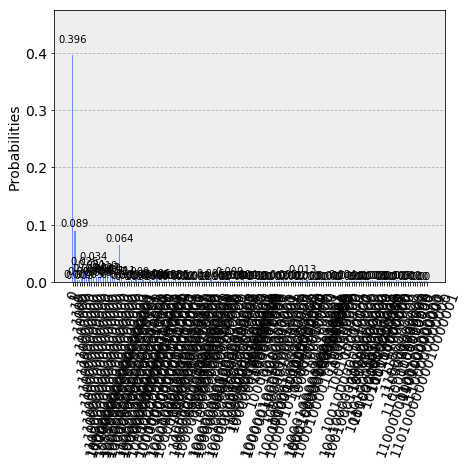

In [311]:
job = backend.retrieve_job('5d8bdd2c29dcfd0011e55a4d')
counts = job.result().get_counts()
counts = {key: value for key, value in counts.items()}
num_ones = sum([value for (key,value) in counts.items() if key[-1] == '1'])
print(num_ones/1024)
plot_histogram(counts)

In [303]:
# Pulse way is:
schedule = pulse.Schedule()

Xp_d0 = [p for p in backend.defaults().pulse_library if p.name=='Xp_d0'][0]
pi_over_3_samples = [val / 3 for val in Xp_d0.samples]
pi_over_3_pulse = SamplePulse(pi_over_3_samples)
schedule |= pi_over_3_pulse(DriveChannel(0))

schedule |= cmd_def.get('measure', qubits=config.meas_map[0]) << schedule.duration
job = execute(schedule, backend=backend)
#print(job.job_id())

5d8bdf474274d500111b6ab5


0.2490234375


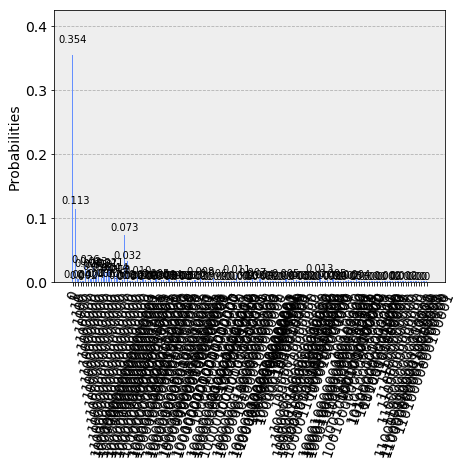

In [312]:
job = backend.retrieve_job('5d8bdf474274d500111b6ab5')
counts = job.result().get_counts()
counts = {key: value for key, value in counts.items()}
num_ones = sum([value for (key,value) in counts.items() if key[-1] == '1'])
print(num_ones/1024)
plot_histogram(counts)